<a href="https://colab.research.google.com/github/ab17254/dissertation/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload config.py with API keys
from google.colab import files
uploaded = files.upload()

Saving config.py to config.py


In [3]:
import os
from config import KaggleKey
os.environ['KAGGLE_USERNAME'] = KaggleKey.kaggle_username
os.environ['KAGGLE_KEY'] = KaggleKey.kaggle_key
!kaggle datasets download -d albrace/twitter-data

twitter-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip /content/twitter-data.zip -d /content/data

Archive:  /content/twitter-data.zip
  inflating: /content/data/2019_all_twitter_data/2019_all_twitter_data.csv  
  inflating: /content/data/bots/bots.csv  
  inflating: /content/data/clean_twitter_data/all_2019.csv  
  inflating: /content/data/clean_twitter_data/all_users.csv  
  inflating: /content/data/clean_twitter_data/pol_actor_users.csv  
  inflating: /content/data/ge2017_cand_data/ge2017_cand_data.csv  
  inflating: /content/data/twitter_data/all_twitter_data.csv  
  inflating: /content/data/twitter_data/political_twitter_data.csv  


In [5]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3MB 133kB/s 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from operator import itemgetter

import re
import tweepy
from tweepy import OAuthHandler
from config import TwitterKeys

In [7]:
consumer_key = TwitterKeys.consumer_key
consumer_secret = TwitterKeys.consumer_secret
access_token = TwitterKeys.access_token
access_token_secret = TwitterKeys.access_token_secret

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
twitter_api = tweepy.API(auth,  wait_on_rate_limit=True)

twitter_app_auth = {
    'consumer_key': consumer_key,
    'consumer_secret': consumer_secret,
    'access_token': access_token,
    'access_token_secret': access_token_secret,
  }

In [8]:
pol_df = pd.read_csv('/content/data/bots/bots.csv', index_col=0)

In [9]:
pol_df.isnull().sum()

score                            0
tweet_date                       0
tweet_content                    0
tweet_id                         0
tweet_likes                      0
tweet_replies                    0
tweet_retweets                   0
tweet_quotes                     0
user_username                    0
user_id                          0
user_followers                   0
user_friends                     0
user_statuses                    0
user_verified                    0
user_url                         0
tweet_url                        0
quotedTweet_id                   0
quotedTweet_content              0
quotedTweet_username             0
quotedTweet_userID               0
hashtags                         0
clean_tweet_content              0
mentioned_users               1026
quotedTweet_mentionedUsers     974
clean_sentiment_content          0
dtype: int64

In [10]:
pol_df = pol_df.dropna(subset=['quotedTweet_username'])


In [11]:
interactions_df = pd.DataFrame(columns=['user_username', 'quotedTweet_username'])
user = []
mentions = []
for row in pol_df.iterrows():
  user.append(row[1]['user_username'])
  mentions.append(row[1]['quotedTweet_username'])
interactions_df['user_username'] = user
interactions_df['quotedTweet_username'] = mentions
interactions_df['quotedTweet_username'] = interactions_df['quotedTweet_username'].str.split()

In [12]:
interactions_df = interactions_df.dropna()

In [13]:
interactions = []
for row in interactions_df.iterrows():
  user = row[1][0]
  mentions = row[1][1]
  for mention in mentions:
    interactions.append((user, mention))

In [14]:
interactions_df = pd.DataFrame(interactions, columns=['user_username', 'quotedTweet_username'])

In [15]:
interactions_df

,user_username,quotedTweet_username
0,ChambersofJD,GdnPolitics
1,K_Ramps,GdnPolitics
2,wisitwippl,GdnPolitics
3,scottymacadamia,GdnPolitics
4,brightonjas,GdnPolitics
...,...,...
1300,LizWebsterLD,BrokenTwitty
1301,johncoxonmedia,PatsyGroomer
1302,GeoffsNZViews,rnz_news
1303,NickPfitzner,heelersbot


In [16]:
interactions_df = interactions_df.replace('nan', np.nan)
interactions_df = interactions_df.dropna()

In [17]:
interactions_df['user_username'] = interactions_df['user_username'].astype('str')
interactions_df['quotedTweet_username'] = interactions_df['quotedTweet_username'].astype('str')

In [18]:
interactions_df=interactions_df.drop([1,2])

In [21]:
graph = nx.from_pandas_edgelist(interactions_df, 'user_username', 'quotedTweet_username')
pos = nx.spring_layout(graph)


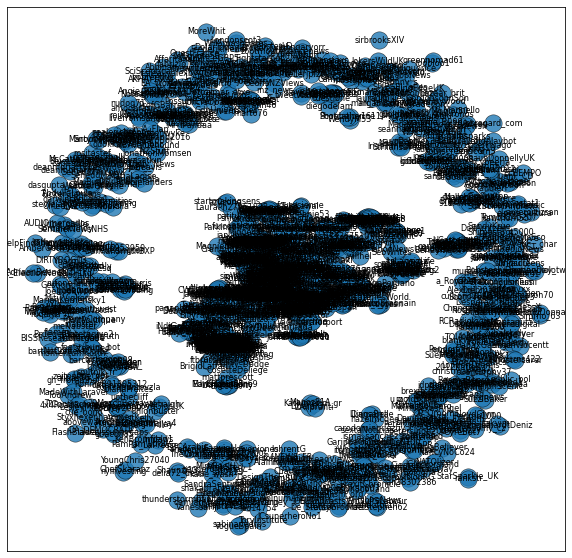

In [22]:
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(graph, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(graph, pos, font_size=8)
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.2)

In [23]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")
degrees = [val for (node, val) in graph.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

There are 1347 nodes and 1140 edges present in the Graph
The maximum degree of the Graph is 74
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 1.7
The most frequent degree of the nodes found in the Graph is 1
The graph is not connected
There are 280 connected components in the Graph


In [24]:
largest_subgraph=list(graph.subgraph(c) for c in nx.connected_components(graph))[0]
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")

    
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")
print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

There are 563 nodes and 611 edges present in the largest component of the Graph
The graph is connected
The average clustering coefficient is 0.002760921105590343 in the largest subgraph
The transitivity of the largest subgraph is 0.0010644589000591367
The diameter of our Graph is 16
The average distance between any two nodes is 6.24


In [25]:
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id GdnPolitics has a degree centrality of 0.13 which is the maximum of the Graph
the node with id smoosh_face has a closeness centrality of 0.26 which is the maximum of the Graph
the node with id JustMeBeingMe4 has a betweenness centrality of 0.42 which is the maximum of the Graph


In [34]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange', 'red', 'blue']
central_nodes = ['JustMeBeingMe4', 'GdnPolitics', 'smoosh_face']
pos = nx.spring_layout(largest_subgraph, k=0.05)

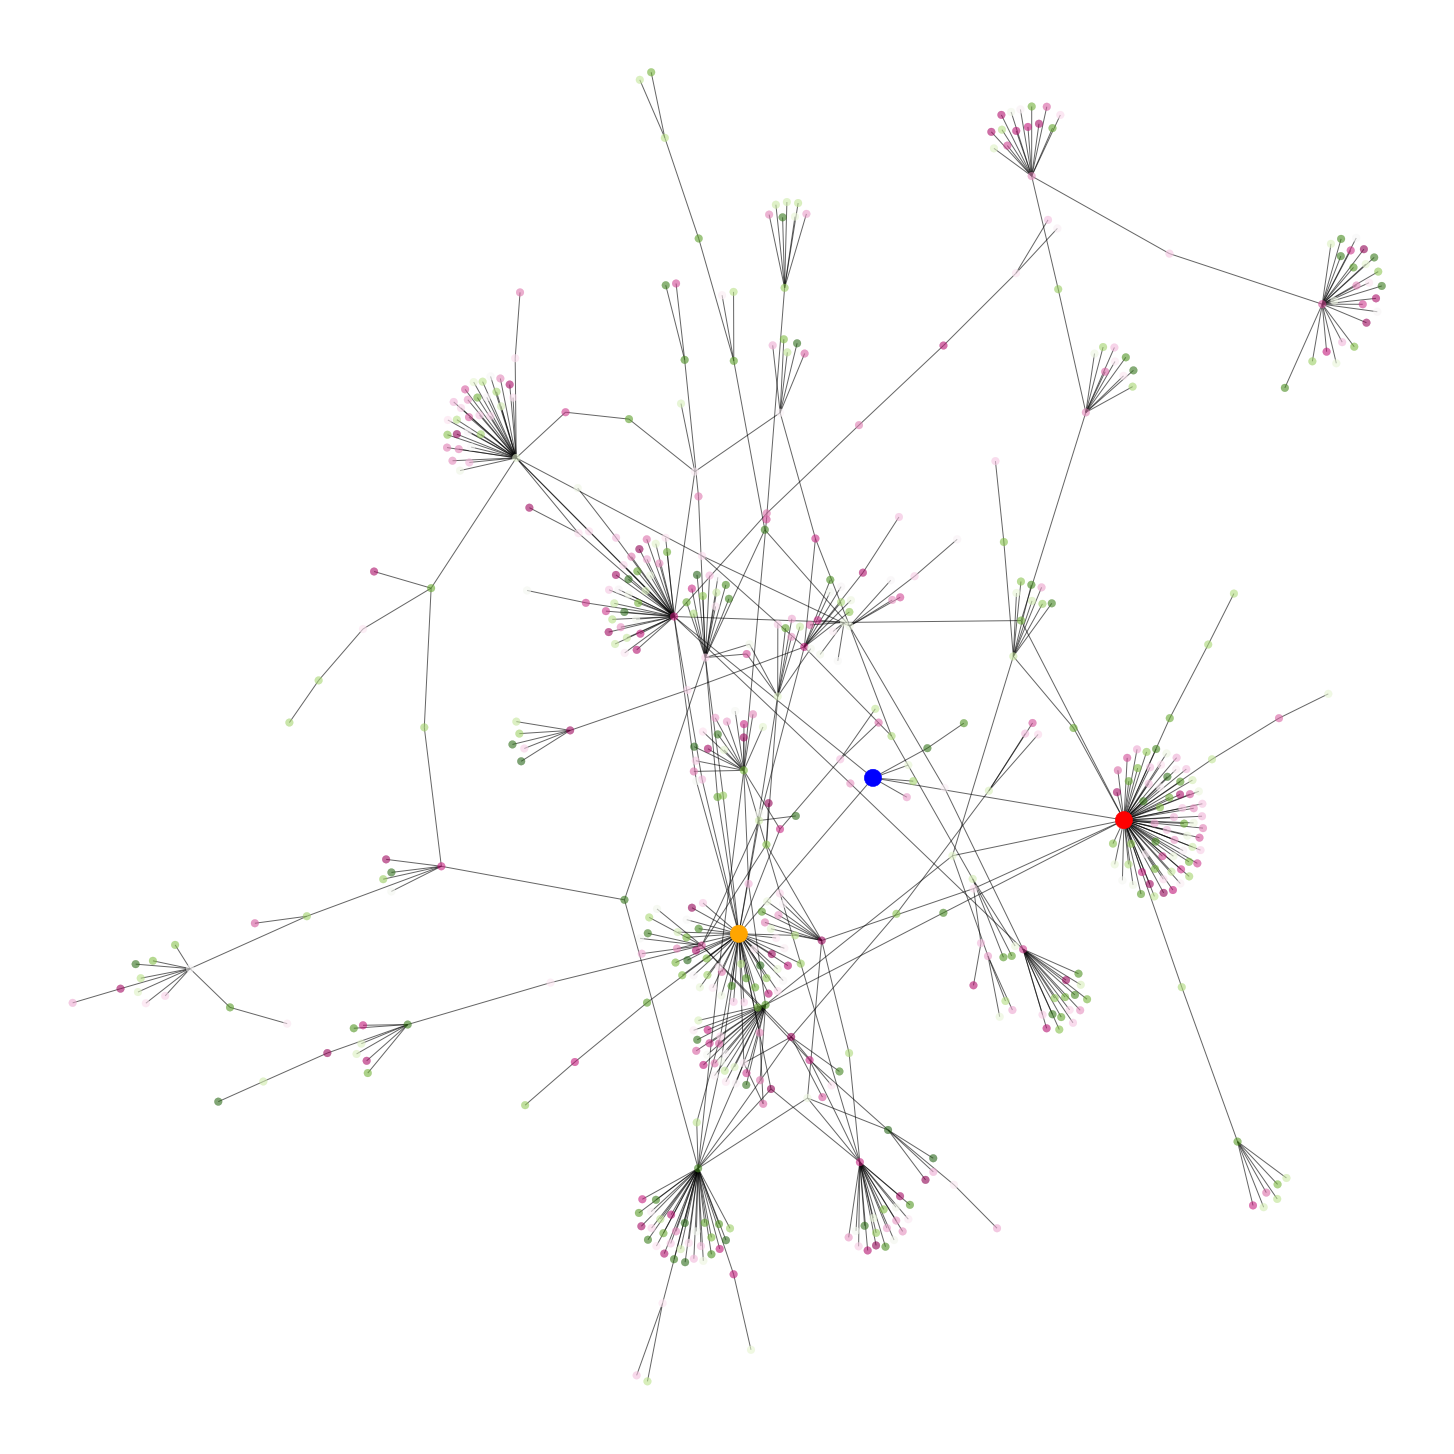

In [35]:
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(563), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.show()

In [ ]:
from community import community_louvain
partition = community_louvain.best_partition(largest_subgraph)
partition1 = pd.DataFrame([partition]).T
partition1 = partition1.reset_index()
partition1.columns = ['names','group']

In [ ]:
G_sorted = pd.DataFrame(sorted(largest_subgraph.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['names','degree']
G_sorted.head()
dc = G_sorted

In [ ]:
combined = pd.merge(dc,partition1, how='left', left_on="names",right_on="names")

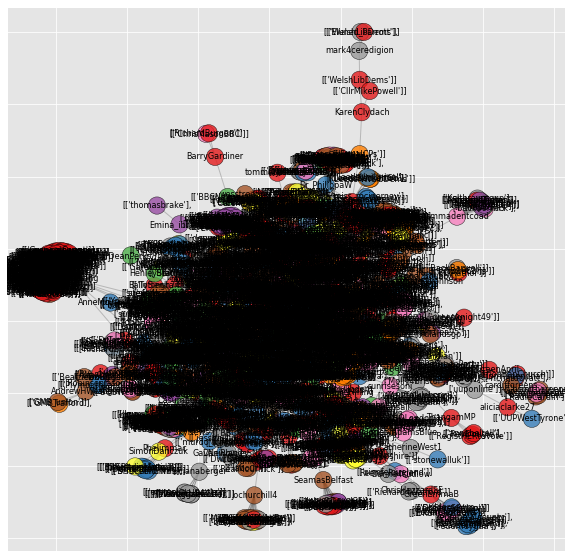

In [ ]:
pos = nx.spring_layout(largest_subgraph)
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(largest_subgraph, pos,
                               cmap=plt.cm.Set1,
                               node_color=combined['group'],
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(largest_subgraph, pos, font_size=8)
nx.draw_networkx_edges(largest_subgraph, pos, width=1.0, alpha=0.2)

In [ ]:
edges = nx.to_pandas_edgelist(largest_subgraph)
edges.to_csv("edges.csv")

combined = combined.rename(columns={"names": "Id"})
nodes = combined['Id']
combined.to_csv('nodes.csv')

### Similarity Matrix

In [ ]:
pol_df = pol_df.sample(n=5000)

In [36]:
pol_df = pol_df.reset_index(drop=True)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(pol_df['quotedTweet_content'])
print(tfidf_matrix.shape)

(1305, 7055)


In [38]:
pol_df['quotedTweet_content'][0]

"b'Have you experienced any voting issues? Share your stories https://t.co/nLXIVyHB9j'"

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_index=cosine_similarity(tfidf_matrix[0],tfidf_matrix)
similarity_index=similarity_index.reshape(-1)

In [40]:
n=6
print(similarity_index[np.argsort(similarity_index)[-n:]])

[0.1201198  0.12015311 0.12037475 0.12729787 0.13776206 1.        ]


In [41]:
res = sorted(range(len(similarity_index)), key = lambda sub: similarity_index[sub])[-n:] 
  
# printing result 
print("Indices list of max N elements is : " + str(res))

Indices list of max N elements is : [734, 514, 1265, 1142, 360, 0]


In [42]:
for i in res:
    print(pol_df['quotedTweet_content'][i], i)
    print('\n')

b'Poll finds twice as many young people register to vote since 2017 election | Latest Brexit news and top stories | The New European https://t.co/kO0oBn2OYw' 734


b"@BorisJohnson I CANNOT believe you have the cheek to say ANYTHING about #ChildrenInNeed2019 when your party have put so many children into absolute poverty!!!\nAnd you don't even know how many children you've got! https://t.co/JJPOLRS8Rs" 514


b'If you voted to leave then you need to know that unless you have a lot of money you will have to use the NHS which will be crippled by Brexit.  #StopBrexit  #PeoplesVote  #nhs https://t.co/rk2X7Ytu82' 1265


b"You have to watch this!!\nIn America you pay $40 or you don't get to hold your baby after its born!\nhttps://t.co/NDymguV6Dm" 1142


b'Also did a video with @nandbkieren discussing disability issues https://t.co/1VsOHKEguf' 360


b'Have you experienced any voting issues? Share your stories https://t.co/nLXIVyHB9j' 0




In [ ]:
tfidf_matrix

<5000x17801 sparse matrix of type '<class 'numpy.float64'>'
	with 143611 stored elements in Compressed Sparse Row format>

In [43]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(affinity='cosine', linkage='single', distance_threshold=0, n_clusters=None).fit(tfidf_matrix.toarray())


In [ ]:
cluster

AgglomerativeClustering(affinity='cosine', distance_threshold=0,
                        linkage='single', n_clusters=None)

In [44]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

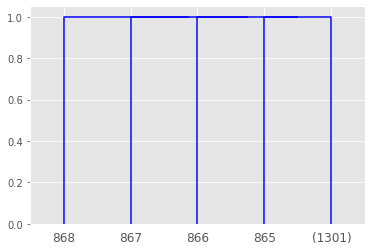

In [45]:
plot_dendrogram(cluster, truncate_mode='level', p=3)
plt.show()

In [46]:
tfidf = TfidfVectorizer(max_features=100)
X = tfidf.fit_transform(pol_df['quotedTweet_content']).todense()

In [48]:
N = X.shape[0]
idx = np.random.choice(N, size=1000, replace=False)
x = X[idx]
labels = pol_df.quotedTweet_username[idx].tolist()


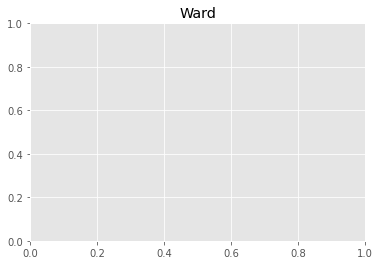

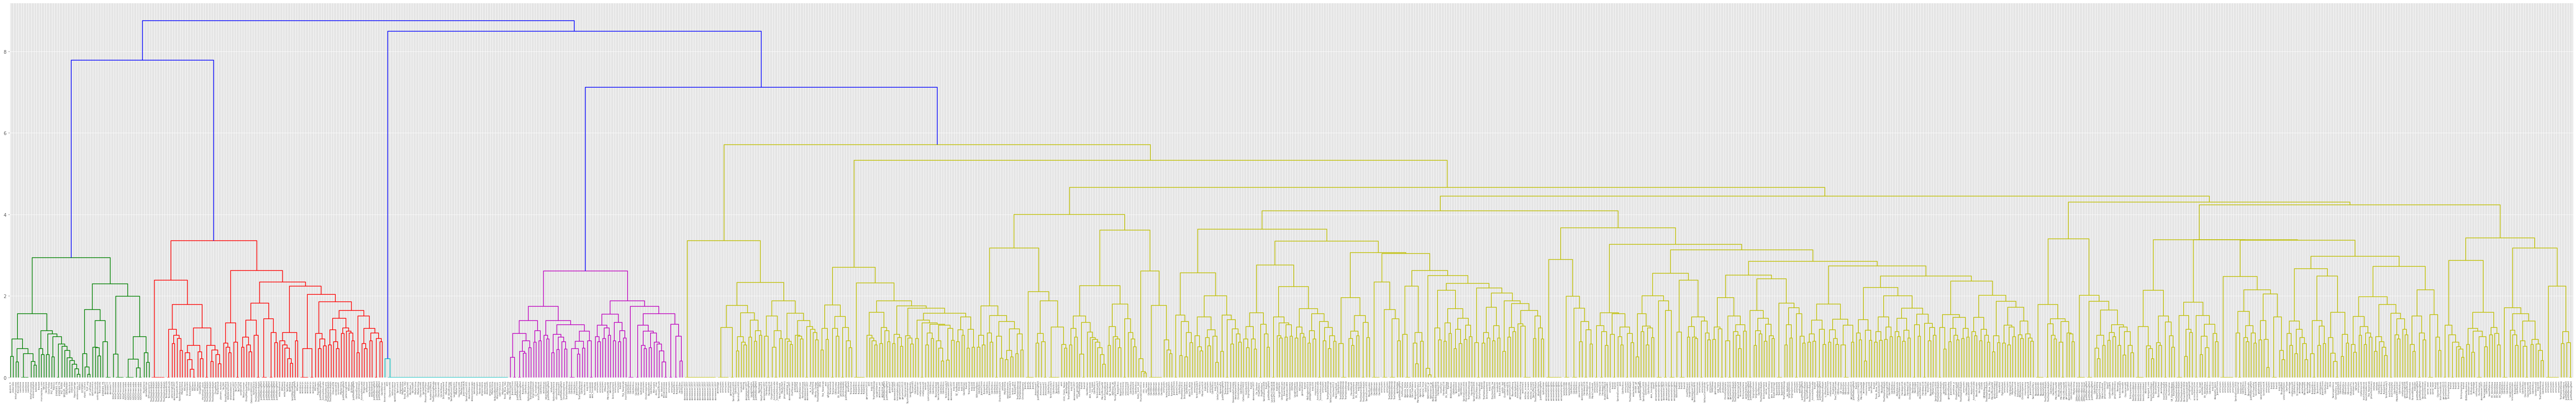

In [50]:
from scipy.spatial.distance import pdist
dist_array = pdist(x)
Z = linkage(dist_array, 'ward')
plt.title("Ward")
plt.figure(figsize = (100,15))
dendrogram(Z, labels=labels)
plt.show()

In [51]:
dist_array

array([1.36251384, 1.35023272, 1.29156013, ..., 1.37277395, 1.3425914 ,
       1.16012702])

In [ ]:
from sklearn import manifold
